## Dependencies

```
91a868ae3dedca688f6feea196235cc319aa621f  ../data/xianzai_phones_loglik.csv   etc/60.18
c4b1bc5bc1dbaa94ca37b56d94f9807a2447412e  ../data/xianzai_feats.csv
```

In [1]:
phones_df_path = "../data/xianzai_phones_loglik.csv"
feats_df_path = "../data/xianzai_feats.csv"
!sha1sum $phones_df_path $feats_df_path

91a868ae3dedca688f6feea196235cc319aa621f  ../data/xianzai_phones_loglik.csv
c4b1bc5bc1dbaa94ca37b56d94f9807a2447412e  ../data/xianzai_feats.csv


## Load Data

In [2]:
import pandas as pd
WORD = "現在"
phones_df = pd.read_csv(phones_df_path)
feats_df = pd.read_csv(feats_df_path)

In [3]:
phones_df.head()

,utt_id,t,phone,ml_phone,sil,spn,a,aj,aw,o,...,ts,tsʰ,ɕ,z,z̩,s,ŋ,ŋ̍,ɻ,ʔ
0,LJH_GY_1479,0,ɕ,tɕʰ,-10.954497,-10.347873,-20.127528,-20.312442,-22.980598,-14.156406,...,-3.638061,-1.631068,-4.957225,-12.812556,-10.866649,-3.369929,-20.649436,-20.649436,-21.597041,-13.621322
1,LJH_GY_1479,1,ɕ,ɕ,-7.828703,-7.426585,-18.372492,-18.293093,-20.348971,-13.979235,...,-3.131583,-2.294741,-1.097899,-14.846644,-12.900733,-1.888304,-19.413104,-19.413104,-21.890116,-15.696814
2,LJH_GY_1479,2,ɕ,tsʰ,-8.536843,-7.032880,-14.579942,-16.695527,-20.671403,-11.590943,...,-5.496541,-0.227296,-5.465466,-11.980321,-10.034413,-7.002271,-18.788117,-18.788117,-22.118104,-18.082459
3,LJH_GY_1479,3,ɕ,tɕʰ,-8.859577,-6.646434,-19.724430,-18.367992,-24.129642,-15.280273,...,-6.059383,-4.051929,-7.072448,-16.135589,-14.189682,-9.297706,-24.051677,-24.051677,-23.327243,-22.819538
4,LJH_GY_1479,4,ɕ,ɕ,-12.557197,-10.119735,-21.076709,-27.767848,-30.382549,-23.913860,...,-5.917732,-7.738178,-0.738494,-19.257945,-17.312038,-8.567615,-27.597476,-27.597476,-23.382205,-21.637256


In [4]:
import re
from typing import cast
from tqdm.auto import tqdm
import numpy as np
from scipy.special import logsumexp
import matplotlib.pyplot as plt

utt_meanP = {}
utt_phoneseq = {}
phone_base_idx = phones_df.columns.values.tolist().index("sil")
phone_table = phones_df.columns[phone_base_idx:].values

for utt_id, utt_df in tqdm(phones_df.groupby("utt_id", sort=False)):
    # utt_df = phones_df.loc[phones_df["utt_id"] == utt_id, :]
    pmat = utt_df.iloc[:, 4:].values

    phone_logPs = []
    phone_seq = []
    for phone, phone_grp in utt_df.groupby("phone", sort=False):
        phone = cast(str, phone)
        phone = re.sub("[\u02e5-\u02e9]+", "", phone)
        phone_idx = utt_df.columns.values.tolist().index(phone)
        phone_logPs.extend(utt_df.iloc[:, phone_idx].values)
        phone_seq.append(phone)
    phone_seq = "".join(phone_seq)
    utt_phoneseq.setdefault(phone_seq, []).append(utt_id)
    utt_meanP[utt_id] = logsumexp(phone_logPs) - np.log(pmat.shape[0])



  0%|          | 0/852 [00:00<?, ?it/s]

In [5]:
pron_df = pd.DataFrame.from_dict(
                      {k: len(v) for k, v in utt_phoneseq.items()}, 
                      orient="index", 
                      columns=["count"]).sort_values(by="count", ascending=False)
pron_df

,count
ɕjentsaj,521
ɕjenaj,269
ɕjenʈʂaj,48
jenaj,8
jentsaj,6


In [6]:
sorted_prons = pron_df.index.values
sorted_prons = [sorted_prons[x] for x in (0,2,1,4,3)]
sorted_prons

['ɕjentsaj', 'ɕjenʈʂaj', 'ɕjenaj', 'jentsaj', 'jenaj']

In [27]:
sorted_utts = []
# only use the standard pronunciations
for pron_x in sorted_prons[0:1]:
  sorted_utts.extend(sorted(utt_phoneseq[pron_x], 
                            key=lambda x: utt_meanP[x]))
sorted_utts = sorted_utts

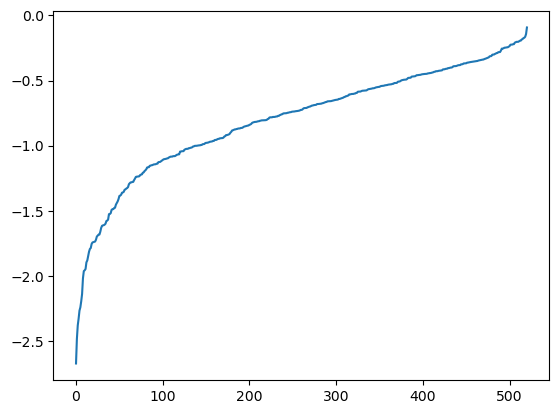

In [28]:
import matplotlib.pyplot as plt
plt.plot([utt_meanP[x] for x in sorted_utts])


In [30]:
from collections import Counter
Counter([x[:x.rindex("_")] for x in sorted_utts]).most_common(10)

[('ZFN_GY', 41),
 ('LJS_GY', 35),
 ('LCX_GY', 30),
 ('CZX_GY', 25),
 ('XMC_GY', 25),
 ('YYS_GY', 22),
 ('ZJZ_GY', 21),
 ('ZXQ_GY', 20),
 ('HYS_GY', 16),
 ('HXF_GY', 14)]

In [41]:
from pathlib import Path
from scipy.io import wavfile
from IPython.display import Audio

wav_dir = Path(f"~/lago/mfa_data/xianzai/s1/").expanduser()
wav_list = []
medians = []
included_utts = [x for x in sorted_utts if x.startswith("HYS_GY")]
for utt_id in included_utts[:5:2]+included_utts[5::3]:  
  print(utt_id)
  sr, wav = wavfile.read(wav_dir / f"{utt_id}.wav")
  wav_list.extend(np.zeros(int(sr*.5), dtype=wav.dtype))
  wav_list.extend(wav)
  

HYS_GY_3178
HYS_GY_3247
HYS_GY_5004
HYS_GY_1896
HYS_GY_3948
HYS_GY_5243
HYS_GY_4212


In [42]:
Audio(wav_list, rate=sr)

In [43]:
wavfile.write("../data/xianzai_stitched.wav", sr, np.array(wav_list, dtype=np.int16))

In [44]:
!sha1sum ../data/xianzai_stitched.wav

558deea6625a573925271b9942504db9fd28c953  ../data/xianzai_stitched.wav
